# 1. Titanic Survivors

In [1]:
# Imports
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# 2. Data Preprocessing
Look at each attribute. Missing values will be filled. Catagorital feastures will be transformed to numberical values.

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
df = train_df.append(test_df, ignore_index=True)
# Some quick inspections
print(train_df.shape, test_df.shape, train_df.columns.values)

(891, 12) (418, 11) ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [3]:
#train_df.head()

In [4]:
#train_df.info()
#print('--------------------------')
#test_df.info()

In [5]:
#train_df.describe()

In [6]:
df.isnull().sum(axis=0)

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Only "Age", "Cabin", "Embarked", "Fare", and "Survived" has null values

In [7]:
#df[df.isnull().any(axis=1)]

### Age

In [8]:
df.Age.isnull().sum()

263

There are 263 missing values in Age. This can be inferred from other feasures, e.g., Title, Fare, SibSp, Parch, etc. will come back to this after finishing inspecting other features. 

### Cabin

### Embarked

### Fare

In [44]:
# check if there is any NAN
df.Fare.isnull().sum(axis=0)

1

Only one missing Fare value. It can probably be inferred from Ticket, Pclass, Cabin, etc. Let's see the corresponding values of for these features.

In [47]:
print(df.Ticket[df.Fare.isnull()],df.Pclass[df.Fare.isnull()],df.Embarked[df.Fare.isnull()],df.Cabin[df.Fare.isnull()])

1043    3
Name: Ticket, dtype: object 1043    3
Name: Pclass, dtype: int64 1043    S
Name: Embarked, dtype: object 1043    NaN
Name: Cabin, dtype: object


There is no corresponding value for Cabin, so only look at the relation between Fare and the other three feasures

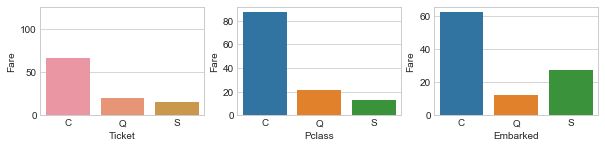

In [56]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3, sharex=True, figsize=(10,2))

Ticket_perc = df[['Ticket','Fare']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Fare',data=Ticket_perc, ax=axis1)

Pclass_perc = df[['Pclass','Fare']].groupby(['Pclass'], as_index=False).mean()
sns.barplot(x='Pclass',y='Fare',data=Pclass_perc, ax=axis2)

Embarked_perc = df[['Embarked','Fare']].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x='Embarked',y='Fare',data=Embarked_perc, ax=axis3)


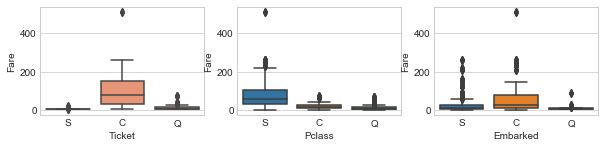

In [57]:
# use boxplot to visualize the distribution of Fare for each Pclass
fig, (axis1, axis2, axis3) = plt.subplots(1,3, sharex=True, figsize=(10,2))
sns.boxplot('Ticket','Fare',data=df, ax=axis1)
sns.boxplot('Pclass','Fare',data=df, ax=axis2)
sns.boxplot('Embarked','Fare',data=df, ax=axis3)

### Name

In [9]:
df.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [10]:
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())
# inspect the amount of people for each title
df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip()).value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Don               1
Sir               1
Mme               1
Dona              1
Lady              1
Jonkheer          1
Capt              1
the Countess      1
Name: Name, dtype: int64

The main titles are: "Mr","Miss","Mrs" & "Master". Some of the others can be merged into one of the four categories. The rest will be merged into "Others"

In [11]:
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df.Title.loc[ (df.Title != 'Master') & (df.Title != 'Mr') & (df.Title != 'Miss') & (df.Title != 'Mrs')] = 'Others'
# inspect the correlation between Title and Survived
#df[['Title','Survived']].groupby(['Title'], as_index=False).mean()

/Users/yanxia/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


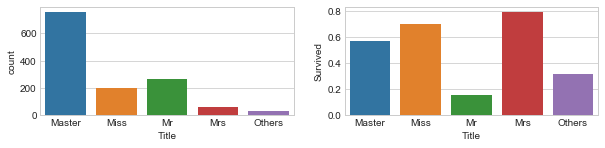

In [12]:
# inspect the amount of people for each title
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Title', data=df,ax=axis1)
#sns.factorplot('Family', data=train_df, kind='count', ax=axis2)

# average of survived for those who had/didn't have any families
family_perc = df[['Title','Survived']].groupby(['Title'], as_index=False).mean()
sns.barplot(x='Title',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

Now we can use dummy variables for these titles and drop the orginal columns. 

In [13]:
df = pd.concat([df, pd.get_dummies(df['Title'])], axis=1).drop(labels=['Name'], axis=1)

### Parch & SibSp

Instead of having 2 columns, Parch and SibSp, we can have only one column representing if the passenger had any families aboard. 

In [14]:
df['Family'] = df['Parch']+df['SibSp']+1
# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


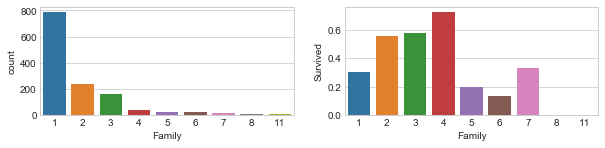

In [15]:
# the number of family members
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=df, ax=axis1)

# average of survived for those who had/didn't have any families
family_perc = df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

In [16]:
# inspect the family size
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

The survivial rate increases with the family size till Family>=5. However, the number of family with >=5 members is only 57. Besides, peole with big families (>=5) have a low survival rate too. Thereby, I will combine the data with Family>4 into one category, Family=5 

In [17]:
df.Family = df.Family.map(lambda x: 5 if x>4 else x)
df[['Family','Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.161290


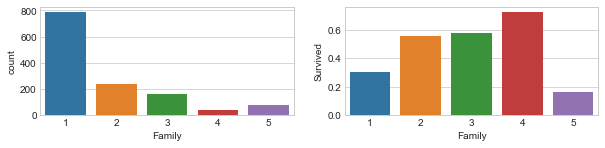

In [18]:
# the number of family members
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=df, ax=axis1)

# average of survived for those who had/didn't have any families
family_perc = df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

In [19]:
# Drop "Parch" & "SibSp"
#df = df.drop(['Parch','SibSp'], axis=1)
#df = df.drop(['Parch','SibSp'], axis=1)

### PassengerId

### Pclass

In [20]:
# check if there are any null values
df['Pclass'].isnull().sum(axis=0)

0

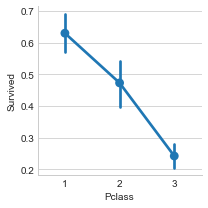

In [21]:
# inspect the corrleatoin between Pclass and survived
#df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
sns.factorplot('Pclass','Survived', order=[1,2,3],data=train_df,size=3)

We can see that a higher class has a higher survival rate. 

Create dummy variable for Pclass & drop the 3 rd class as it has the lowest average of survived passengers

In [22]:
pclass_dummies_df = pd.get_dummies(df['Pclass'])
pclass_dummies_df.columns = ['Class1','Class2','Class3']
#pclass_dummies_df.drop(['Class3'], axis=1, inplace=True)

#df.drop(['Pclass'], axis=1, inplace=True)

df = df.join(pclass_dummies_df)



In [23]:
# Drop useless columns
#train_df = train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
#test_df = test_df.drop(['Name','Ticket'], axis=1)

In [24]:
# Fill in NaN values of Age with the mean value



### Sex

As we see, children (age<16) on aboard eem to have a high chances for survival. so we can classify passengers as males, females, and child

In [25]:
df.Sex.isnull().sum(axis=0)

0

In [26]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [27]:
# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

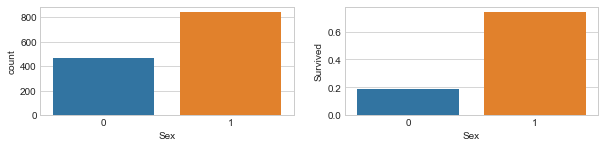

In [28]:
# inspect the correlation between Sex and Survived 
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Sex', data=df, order=[1,0],ax=axis1)

sex_perc = df[['Sex','Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot(x='Sex',y='Survived',data=sex_perc, ax=axis2)

In [29]:
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

df['Person'] = df[['Age','Sex']].apply(get_person, axis=1)

In [30]:
df['Person'].head()

0    0
1    1
2    1
3    1
4    0
Name: Person, dtype: object

In [31]:
# No need to use sex col since we created person col
df.drop(['Sex'],axis=1,inplace=True)

In [32]:
# Create dummy variables for Person column, & drop male as it has the lowest average of surved passengers
person_dummies_df = pd.get_dummies(df['Person'])
#person_dummies_df.columns = ['Child','Female','Male']
#person_dummies_df.drop(['Male'],axis=1, inplace=True)

#df = df.join(person_dummies_df)

In [33]:
# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

AttributeError: 'DataFrame' object has no attribute 'Sex'

### Ticket

In [34]:
df.Ticket.isnull().sum(axis=0)

0

In [35]:
df.Ticket.head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

It seems like there are two types of tickects: (1)number only (2) letter+number. Tickets start with letters probably represent some special classes, and the first digit of the numbers may prepresent the class. 

In [41]:
df.Ticket = df.Ticket.map(lambda x:x[0])
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
F     13
7     13
4     11
6      9
L      5
5      3
8      2
9      2
Name: Ticket, dtype: int64

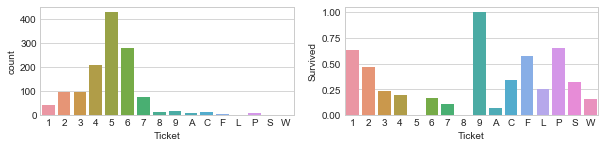

In [38]:
# inspect the amount of people for each type of tickets
#df['Ticket'].value_counts()
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Ticket', data=df, ax=axis1)
# inspect the correlatin between Ticket and Survived
#df[['Ticket','Survived']].groupby(['Ticket'], as_index=False).mean()
sex_perc = df[['Ticket','Survived']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Survived',data=sex_perc, ax=axis2)

We can see here that the majority of the tickest are "1","2","3", and their survival rates are "1">"2">"3". The rates for others are low, except for "9"(2),"C"(77),"F"(13),"P"(98), and "S"(98). "9""F" are very small samples. The high rates here are probably from Pclass or Fase. Let's check. 

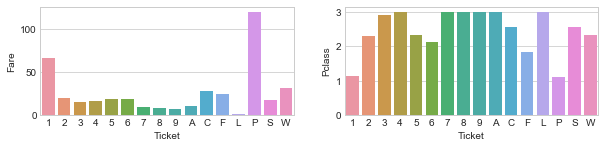

In [43]:
#df[['Ticket', 'Fare']].groupby(['Ticket'], as_index=False).mean()
#df[['Ticket', 'Pclass']].groupby(['Ticket'], as_index=False).mean()

fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))

fare_perc = df[['Ticket','Fare']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Fare',data=fare_perc, ax=axis1)
Pclass_perc = df[['Ticket','Pclass']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Pclass',data=Pclass_perc, ax=axis2)

### 3.2 Embarked

In [ ]:
# Fill in NaN values of Embarked 
train_df['Embarked'].value_counts()

In [ ]:
train_df = train_df.fillna({'Embarked':'S'})

In [ ]:
# Fill in NaN values of Cabin


In [ ]:
# plot
sns.factorplot('Embarked', 'Survived', data=train_df, size=2, aspect=2)

fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,2))
sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue='Embarked',data=train_df, order=[1,0],ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived',data=embark_perc, order=['S','C','Q'],ax=axis3)

In [ ]:
#  Remove 'S' dummy variable, and leave 'C' and 'Q', since they seem to have a good rate for survival. 
embark_dummies_titanic = pd.get_dummies(train_df['Embarked'])
embark_dummies_titanic.drop('S', axis=1, inplace=True)

embark_dummies_test = pd.get_dummies(train_df['Embarked'])
embark_dummies_test.drop('S', axis=1, inplace=True)

train_df = train_df.join(embark_dummies_titanic)
test_df = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

### 3.3 Fare


In [ ]:
# Only for test_df, since there is a missing 'Fare' value
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)
# convert float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

# Get fare for survived & didn't survived passengers
fare_not_survived = train_df['Fare'][train_df['Survived'] == 0]
fare_survived = train_df['Fare'][train_df['Survived'] == 1]

# Get average and std for fare of survived/not survived passengers
average_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
train_df['Fare'].plot(kind='hist', figsize=[15,3],bins=100,xlim=(0,50))

average_fare.index.names = std_fare.index.names = ['Survived']
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

### 3.4 Age

In [ ]:
# get average, std, and number of NaN values in train_df
averge_age_titanic = train_df['Age'].mean()
std_age_titanic = train_df['Age'].std()
count_nan_age_titanic = train_df['Age'].isnull().sum()
# get average, std, and number of NaN values in test_df
averge_age_test = test_df['Age'].mean()
std_age_test = test_df['Age'].std()
count_nan_age_test = test_df['Age'].isnull().sum()
# generate random numbers between (mean-std) & (mean+std)
rand_1 = np.random.randint(averge_age_titanic-std_age_titanic, averge_age_titanic+std_age_titanic, size=count_nan_age_titanic)
rand_2 = np.random.randint(averge_age_test-std_age_test, averge_age_titanic+std_age_test, size=count_nan_age_test)


In [ ]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')
# plot original Age values
# NOTE: drop all null values, and convert to int
train_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_df['Age'][np.isnan(train_df['Age'])] = rand_1
test_df['Age'][np.isnan(test_df['Age'])] = rand_2

# convert from float to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)
# plot new Age values
train_df['Age'].hist(bins=70, ax=axis2)

In [ ]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_df, hue = 'Survived', aspect=4)
facet.map(sns.distplot, 'Age')
#facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

# Averge survived passeangers by age
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
average_age = train_df[['Age','Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

### 3.5 Cabin

In [ ]:
# As it has a lot of NaN values, so it won't cause a remarkable impact on prediction
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

### 3.6 Family

In [ ]:
# Instead of having two col Parch & SibSp, 
# we can have only one col represent if the passenger had any 
# family member aboard or not
# Meaning, if having any family member will increase chances of survial 
train_df['Family'] = train_df['Parch']+train_df['SibSp']
train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0
test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0


In [ ]:
# Drop "Parch" & "SibSp"
train_df = train_df.drop(['Parch','SibSp'], axis=1)
test_df = test_df.drop(['Parch','SibSp'], axis=1)

In [ ]:
# plot
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=train_df, order=[1,0],ax=axis1)
#sns.factorplot('Family', data=train_df, kind='count', ax=axis2)

# average of survived for those who had/didn't have any families
family_perc = train_df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc,order=[1,0], ax=axis2)
axis1.set_xticklabels(['With Family','Alone'],rotation=0)

### 3.7 Sex

In [ ]:
# As we see, childer (age<16) on aboard eem to have a high chances for survival. so we can classify passengers as males, females, and child

def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

train_df['Person'] = train_df[['Age','Sex']].apply(get_person, axis=1)
test_df['Person'] = test_df[['Age','Sex']].apply(get_person, axis=1)

In [ ]:
# No need to use sex col since we created person col
train_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)

In [ ]:
# Create dummy variables for Person column, & drop maile as it has the lowest average of surved passengers
person_dummies_titanic = pd.get_dummies(train_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'],axis=1, inplace=True)
person_dummies_test = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'],axis=1, inplace=True)

train_df = train_df.join(person_dummies_titanic)
test_df = test_df.join(person_dummies_test)

In [ ]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(10,2))
# plot # of different people
sns.countplot(x='Person',data=train_df, ax=axis1)

# average of survived for each person(male, female or child)
person_perc = train_df[['Person','Survived']].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person',y='Survived', data=person_perc,ax=axis2,order=['male','female','child'])

train_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

### 3.8 Pclase

In [ ]:
sns.factorplot('Pclass','Survived', order=[1,2,3],data=train_df,size=2)

In [ ]:
# create dummy variable for Pclass column & drop 3 rd class as it has the lowest average of survived passengers 
pclass_dummies_titanic = pd.get_dummies(train_df['Pclass'])
pclass_dummies_titanic.columns = ['Class1','Class2','Class3']
pclass_dummies_titanic.drop(['Class3'], axis=1, inplace=True)

pclass_dummies_test = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class1','Class2','Class3']
pclass_dummies_test.drop(['Class3'], axis=1, inplace=True)

train_df.drop(['Pclass'], axis=1, inplace=True)
test_df.drop(['Pclass'], axis=1, inplace=True)

train_df = train_df.join(pclass_dummies_titanic)
test_df = test_df.join(pclass_dummies_test)


# 4. Training & Testing

In [ ]:
# define training and testing sets
X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train

In [ ]:
# Logistic Regress
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
#logreg.score(X_train, Y_train)
logreg.score(X_train, Y_train)


In [ ]:
# SVM

In [ ]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
svc.score(X_train,Y_train)

In [ ]:
# Ramdom Forests
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
rf.score(X_train,Y_train)

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn.score(X_train, Y_train)

In [ ]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
gaussian.score(X_train, Y_train)

In [ ]:
# get Correlation Coefficient for each feasure using Logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(logreg.coef_[0])
coeff_df

# 5 Submission

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)